In [1]:
import torch
import itertools
import numpy as np
import torch.nn as nn
import torch_optimizer as optim
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, minmax_scale

In [2]:
diabetes = load_diabetes()
inputs, vectors = diabetes.data, diabetes.target

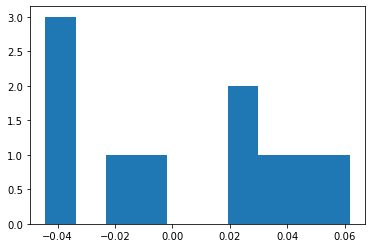

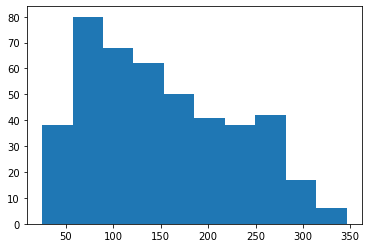

In [3]:
plt.hist(inputs[0])
plt.show()
plt.hist(vectors)
plt.show()

In [4]:
scaler = StandardScaler().fit(inputs)
inputs = scaler.transform(inputs)
vectors = minmax_scale(vectors)

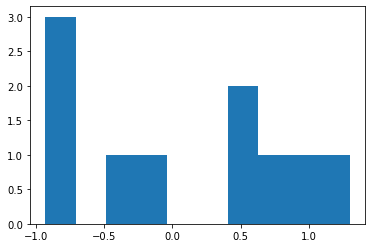

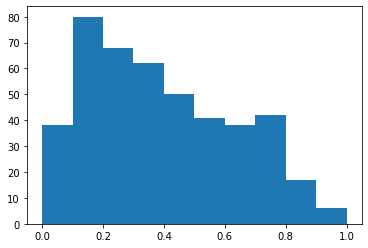

In [5]:
plt.hist(inputs[0])
plt.show()
plt.hist(vectors)
plt.show()

In [6]:
inputs = torch.tensor(inputs, dtype=torch.float32, device='cuda')
vectors = torch.tensor(vectors, dtype=torch.float32, device='cuda')

In [7]:
N = inputs.size(dim=1)

# MLP

In [8]:
@torch.jit.script
def loss_func(batch_size: int, outputs, vectors):
    loss = torch.sum((outputs - vectors)**2) / batch_size
    return loss

In [48]:
k = 64
model = torch.jit.script(
            torch.nn.Sequential(
                nn.Linear(N, k, bias=True),
                torch.nn.ReLU(),
#                 nn.Linear(k, k, bias=True),
#                 torch.nn.ReLU(),
                nn.Linear(k, 1, bias=False),
#                 torch.nn.Sigmoid()
            )
    ).to('cuda')
# state = model.state_dict()
# state['0.bias'] += 0.0
# model.load_state_dict(state)

print(model)
print(inputs.size())
print(vectors.size())
optimizer = optim.Lamb(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2**9, eta_min=0)

losses = []
training_steps = 5000
# batch_size = 200
batch_size = inputs.size(dim=0)
# model.train()
for i in range(training_steps):
    optimizer.zero_grad(set_to_none=True)
    outputs = model.forward(inputs)
#     loss = loss_func(batch_size, outputs, vectors)
    loss = torch.nn.MSELoss()(torch.squeeze(outputs), vectors)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.to('cpu').detach().numpy())
#     perm = torch.randperm(inputs.size()[0])
#     inputs = inputs[perm]
#     vectors = vectors[perm]

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
)
torch.Size([442, 10])
torch.Size([442])


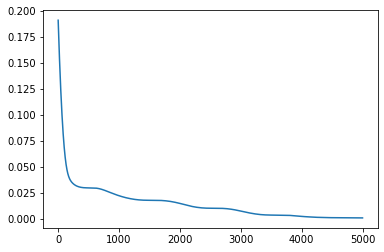

In [49]:
plt.plot(range(training_steps), losses)
# plt.yscale('log')
plt.show()

In [50]:
losses[-1]

array(0.00074388, dtype=float32)

In [51]:
# outputs

In [52]:
# vectors

In [53]:
step_size = .05
os = []
min_i, max_i = np.min(inputs.to('cpu').detach().numpy()[:,0]), np.max(inputs.to('cpu').detach().numpy()[:,0])
# print(len(np.arange(0, 1 + step_size, step_size)))
for i,a in enumerate(np.arange(min_i - step_size, max_i + 2*step_size, step_size)):
    ins = torch.eye(N) * a
#     print(ins)
    o = model.to('cpu').forward(ins).T.detach().numpy()[0]
#     print(o)
    os.append(o)
os = np.array(os)

In [54]:
os

array([[ 4.33098704e-01,  1.15378189e+00,  4.93468285e-01,
         1.32613510e-01, -1.54513136e-01,  1.79037824e-01,
         2.93502033e-01,  3.44873846e-01,  2.07625151e-01,
         4.77587640e-01],
       [ 4.28213298e-01,  1.11916065e+00,  4.65875894e-01,
         1.37377977e-01, -1.47241920e-01,  1.84018210e-01,
         2.85957962e-01,  3.36506933e-01,  2.08533779e-01,
         4.63948280e-01],
       [ 4.23327893e-01,  1.08656561e+00,  4.38283294e-01,
         1.42142475e-01, -1.39894322e-01,  1.88292980e-01,
         2.78414041e-01,  3.28140110e-01,  2.09442303e-01,
         4.50308442e-01],
       [ 4.18442637e-01,  1.05675423e+00,  4.10690933e-01,
         1.43872187e-01, -1.31959245e-01,  1.92567825e-01,
         2.70870209e-01,  3.19773346e-01,  2.10350737e-01,
         4.36668962e-01],
       [ 4.13557261e-01,  1.02694249e+00,  3.84091735e-01,
         1.45388052e-01, -1.24023795e-01,  1.96842641e-01,
         2.63326228e-01,  3.11406374e-01,  2.11259201e-01,
         4.

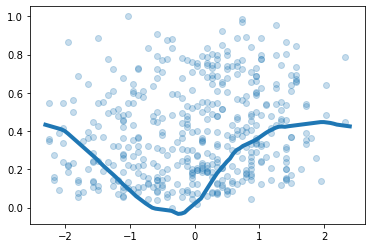

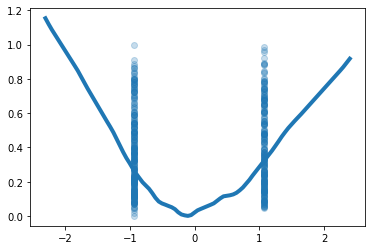

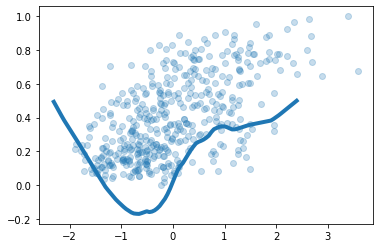

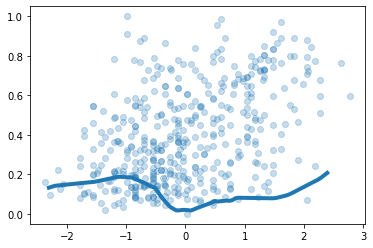

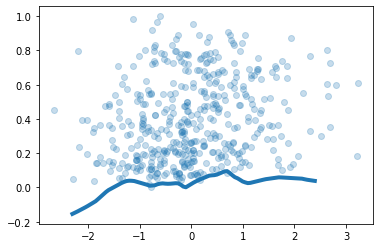

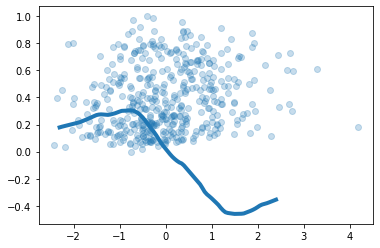

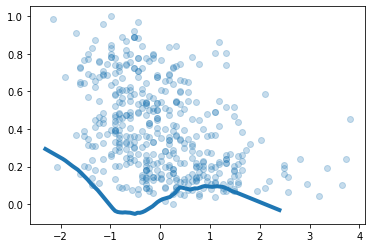

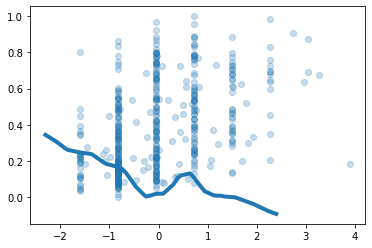

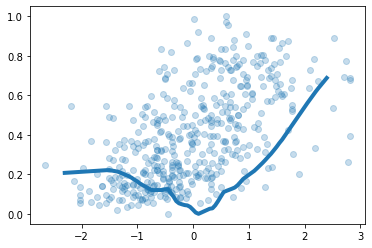

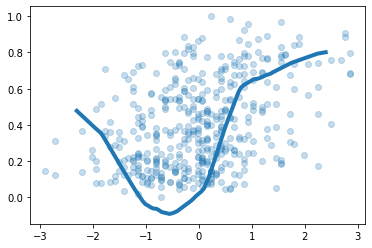

In [55]:
for l in range(N):
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), os[:,l], lw=4)
    plt.scatter(inputs.to('cpu').detach().numpy()[:,l], vectors.to('cpu').detach().numpy(), alpha=0.25)
    plt.show()

# Linear Regression

In [ ]:
regr = LinearRegression()
regr.fit(inputs.to('cpu').detach().numpy(), vectors.to('cpu').detach().numpy())

In [ ]:
mean_squared_error(vectors.to('cpu').detach().numpy(), regr.predict(inputs.to('cpu').detach().numpy()))

In [ ]:
loss_func(batch_size, torch.tensor(regr.predict(inputs.to('cpu').detach().numpy()), dtype=torch.float32, device='cuda'), vectors)

# sklearn.neural_network.MLPRegressor

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100,), tol=1e-2, max_iter=500, random_state=0, batch_size=batch_size)
mlp.fit(inputs.to('cpu').detach().numpy(), vectors.to('cpu').detach().numpy())

In [ ]:
mean_squared_error(vectors.to('cpu').detach().numpy(), mlp.predict(inputs.to('cpu').detach().numpy()))

In [ ]:
loss_func(batch_size, torch.tensor(mlp.predict(inputs.to('cpu').detach().numpy()), dtype=torch.float32, device='cuda'), vectors)

In [ ]:
mlp.n_features_in_

In [ ]:
mlp.n_layers_

In [ ]:
mlp.n_outputs_

In [ ]:
mlp.out_activation_